# Image Classification:

- This is a mini project executed to showcase the concept for image classification using state-of-art architectures - for example: resnet18.
- Here, we will be using a sample dataset of cats & dogs (basically a binary classification problem).


In [1]:
import torchvision # computer vision
import torch.nn as nn  # to use direct layers
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim

import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

!pip install torch_summary
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!rm -rf AAI.zip AAI
!wget -q "https://www.dropbox.com/s/bnzk44uw48o1clu/AAI.zip"

In [4]:
!unzip -q AAI.zip
!ls AAI/classification

test  train


In [17]:
train_data_dir = '/content/drive/MyDrive/AAI-tutorial data/classification/train'
test_data_dir = '/content/drive/MyDrive/AAI-tutorial data/classification/test'

- Following is a class inherited from the Pytorch Dataset class
- It includes adding equal number (500) of data in both the target classes
- get item method returns this index image from the filepath, reads it, crops it to size required by the model, converts it to tensor and permutes it in a way that Pytorch can read it
- While leveraging pre-trained models, it is mandatory to resize, permute, and then normalize images (as appropriate for that pre- trained model), where the images are first scaled to a value between 0 and 1 across the 3 channels and then normalized to a mean of [0.485, 0.456, 0.406] and a standard deviation of [0.229, 0.224, 0.225] across the RGB channels.
- The values used for normalizing are the same mean and standard deviation that was used during the training of the pre-trained model.

In [18]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        # picking only 500 cats & dogs images at a time
        self.fpaths = cats[:500] + dogs[:500]
        # transform the images with the pre calculated mean & standard deviations from imagenet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        # randomizing the images instead of getting trained on a sequence of dogs & then cats
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        # getting the class labels for the images
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    def __len__(self):
        # to get the length of paths taken ( num of images picked)
        return len(self.fpaths)
    def __getitem__(self, ix):
        '''This function loads image & creates an instance - basically a pre-processing function which takes the index of the file name & takes the target name,
        then reads the image using cv2.

        Post that, transforming the image for comaptibility to imagenet model as follows:
        1. As, cv2 reads the image in BGR ; we are changing it to RGB for imagenet model by taking the third index & reversing it.
        2. Resizing the image to 224 * 224 for imagenet model compatibility
        3. As, in Imagenet model they are normalized using 0 to 255 size for each image, perfroming the same normalization.
        4. As cv2 reads the image in sequence 224 * 224 * 3 but the imagenet has the image in format as 3 * 224 * 224. Hence, we are
        permuting & re-arranging the indexes in the same way as 2,0,1.
        5. Finally, normalizing the channels using z-score normalization.

        At this point, we have our image ready for imagenet model; which is taken to GPU after conversion to float.
        '''
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = cv2.imread(f)[:,:,::-1] #cv2 imread reads the image as BGR in default, so the code changes it to RGB
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [19]:
# Getting the filenames of batch of images
data = CatsDogs(train_data_dir)
print(data.__len__())

1000


We can see, its correctly loading 1000 images ( 500 from dogs & 500 from cats classes).

Let's look at a image out of the batch.

tensor([1.], device='cuda:0')
Dog


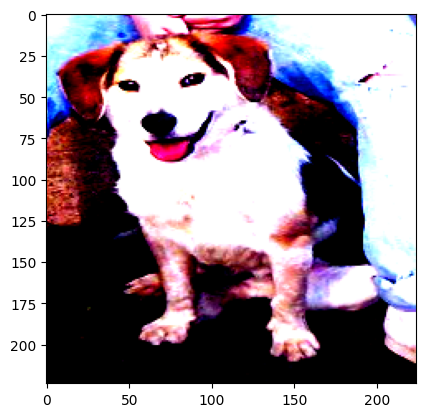

In [20]:
im, label = data[390]
# permute is to just keep it in the matplotlib way to display it
plt.imshow(im.permute(1,2,0).cpu())
print(label)
if label:
    print("Dog")
else:
    print("Cat")

# Modelling:
This function gets the pretrained model from torch repository.
Here, we are taking the resnet18 model for instance with its pre-trained weights, defining that -
- we dont want to modify the parameters of the existing model.
  - However, we will be putting dense layers on top of this model for our classification problem.
  - We are adding a pooling layer to the size of 1,1
- Creating a pipeline using nn.sequential & adding it as a 'fully connected layer'.
  - flattening the image volume from 1 * 1 * 512 to 512 size vector.
  - Adding a linear layer which gives output of 128 size.
  - Adding a droput layer followed by another linear layer giving us a single neuron.
- As our problem is of binary classification in nature, we applied a sigmoid activation function with a binary cross entropy loss.
(If we would have had 2 neurons, we would have used softmax activation & categorical cross entropy loss).


In [21]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1)) #same as pooling.
    #Stride = (input_size//output_size)  ; Kernel size = input_size - (output_size-1)*stride ; Padding = 0
    #https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [22]:
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-1                   [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    └─BasicBlock: 2-2                   [-1, 64, 56, 56]  

## Training function

In [23]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

## Accuracy Function

In [24]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [25]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    test = CatsDogs(test_data_dir)
    test_dl = DataLoader(test, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, test_dl

In [26]:
trn_dl, test_dl = get_data()
model, loss_fn, optimizer = get_model()

In [27]:
train_losses, train_accuracies = [], []
test_accuracies = []

print("All losses and accuracies are for each epoch")
for epoch in range(2):

    train_epoch_losses, train_epoch_accuracies = [], []
    test_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        test_is_correct = accuracy(x, y, model)
        test_epoch_accuracies.extend(test_is_correct)
    test_epoch_accuracy = np.mean(test_epoch_accuracies)

    print(f" epoch {epoch + 1}/5, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Test Accuracy: {test_epoch_accuracy}")
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    test_accuracies.append(test_epoch_accuracy)

All losses and accuracies are for each epoch
 epoch 1/5, Training Loss: 0.2793454280303371, Training Accuracy: 0.96875, Test Accuracy: 0.9652777777777778
 epoch 2/5, Training Loss: 0.12381056251545106, Training Accuracy: 0.9838709677419355, Test Accuracy: 0.9722222222222222
